# **📺Netflix EDA📊+🍿Movies and Shows Recommendation System🎬**

In [139]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import os

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

# Loading the dataset

In [3]:
netflix_overall=pd.read_csv("data/netflix-shows/netflix_titles.csv")
netflix_overall.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
netflix_overall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Remove the 3 rows in which duration is null.

In [5]:
netflix_overall = netflix_overall[~netflix_overall['duration'].isnull()]

In [6]:
netflix_shows=netflix_overall[netflix_overall['type']=='TV Show']
netflix_movies=netflix_overall[netflix_overall['type']=='Movie']

# Analysis of Movies vs TV Shows.

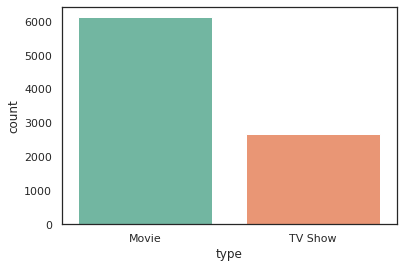

In [7]:
sns.set(style="white")
ax = sns.countplot(x="type", data=netflix_overall, palette="Set2")

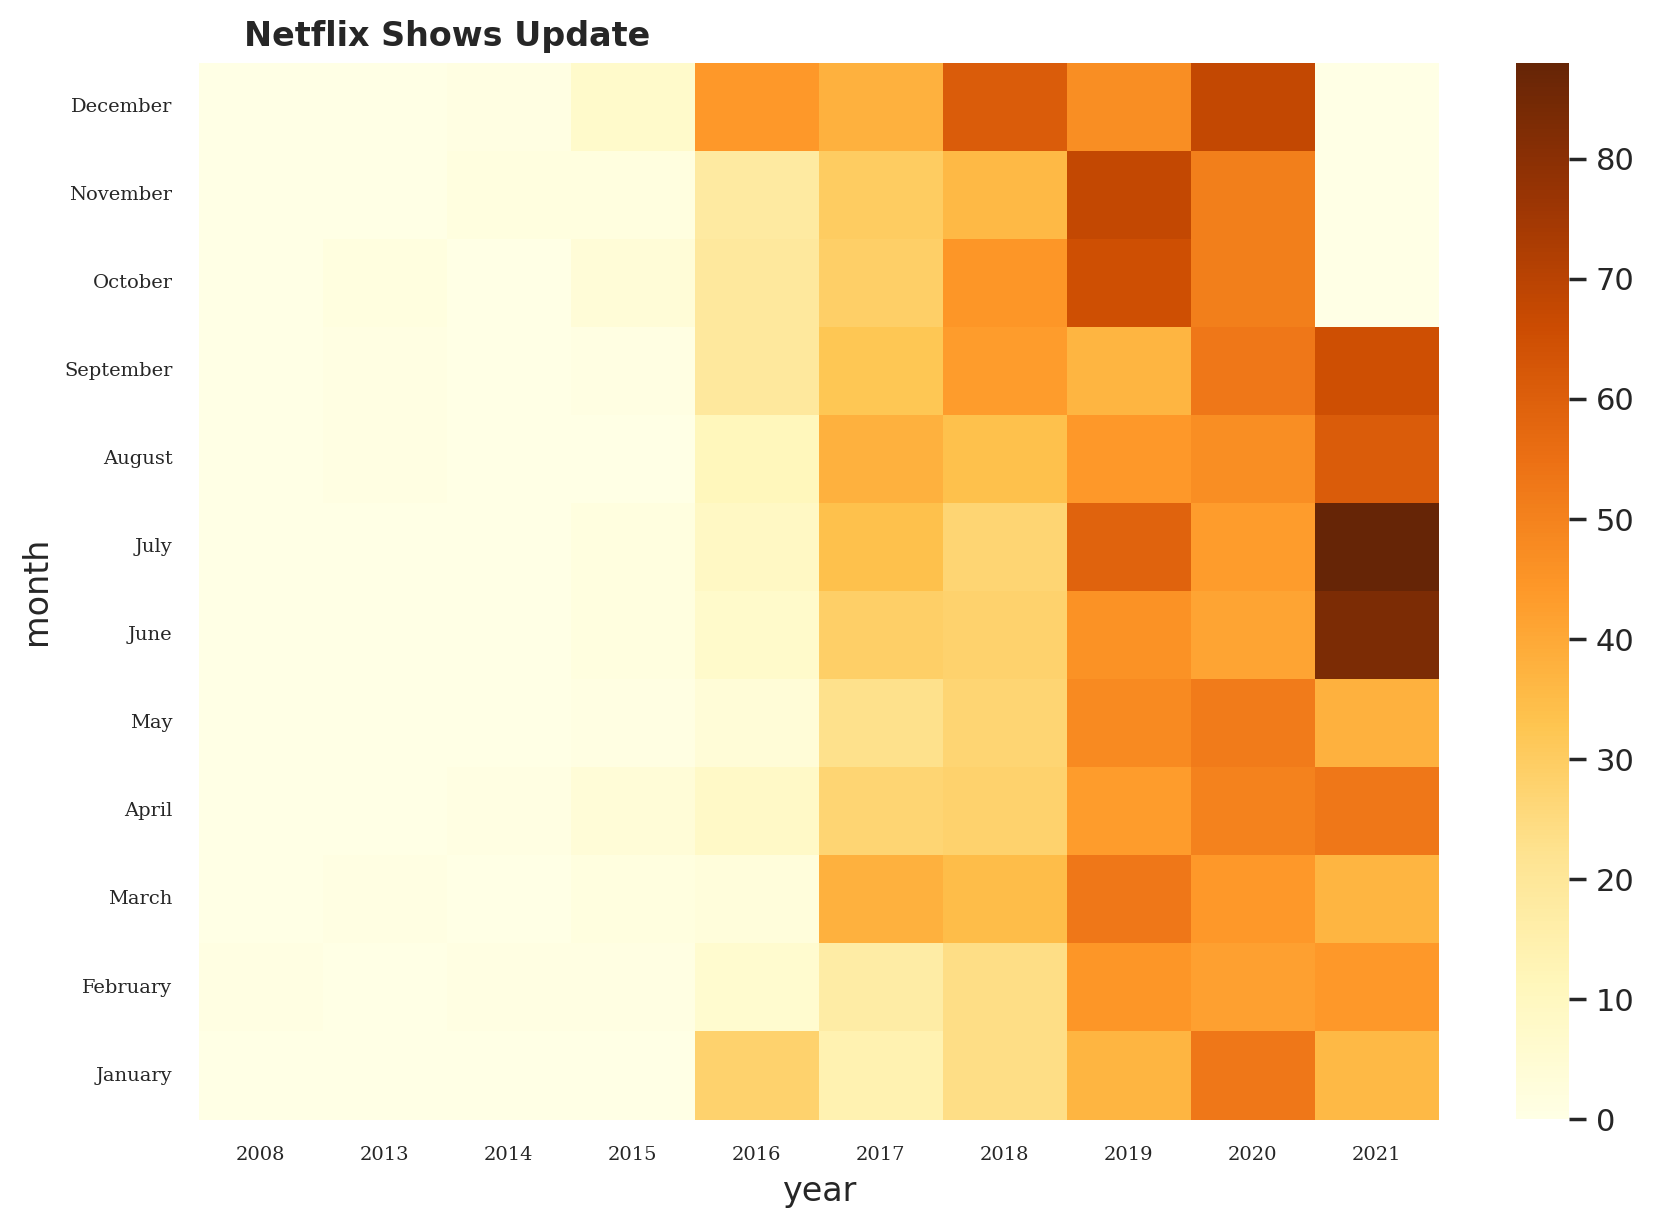

In [8]:
netflix_date = netflix_shows[['date_added']].dropna()
netflix_date['year'] = netflix_date['date_added'].apply(lambda x : x.split(', ')[-1])
netflix_date['month'] = netflix_date['date_added'].apply(lambda x : x.lstrip().split(' ')[0])

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'][::-1]
df = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

plt.figure(figsize=(10, 7), dpi=200)
sns.heatmap(df, cmap="YlOrBr")
plt.title('Netflix Shows Update', fontsize=12, fontfamily='calibri', fontweight='bold', position=(0.20, 1.0+0.02))
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=7, fontfamily='serif')
plt.show()

# Movie ratings analysis

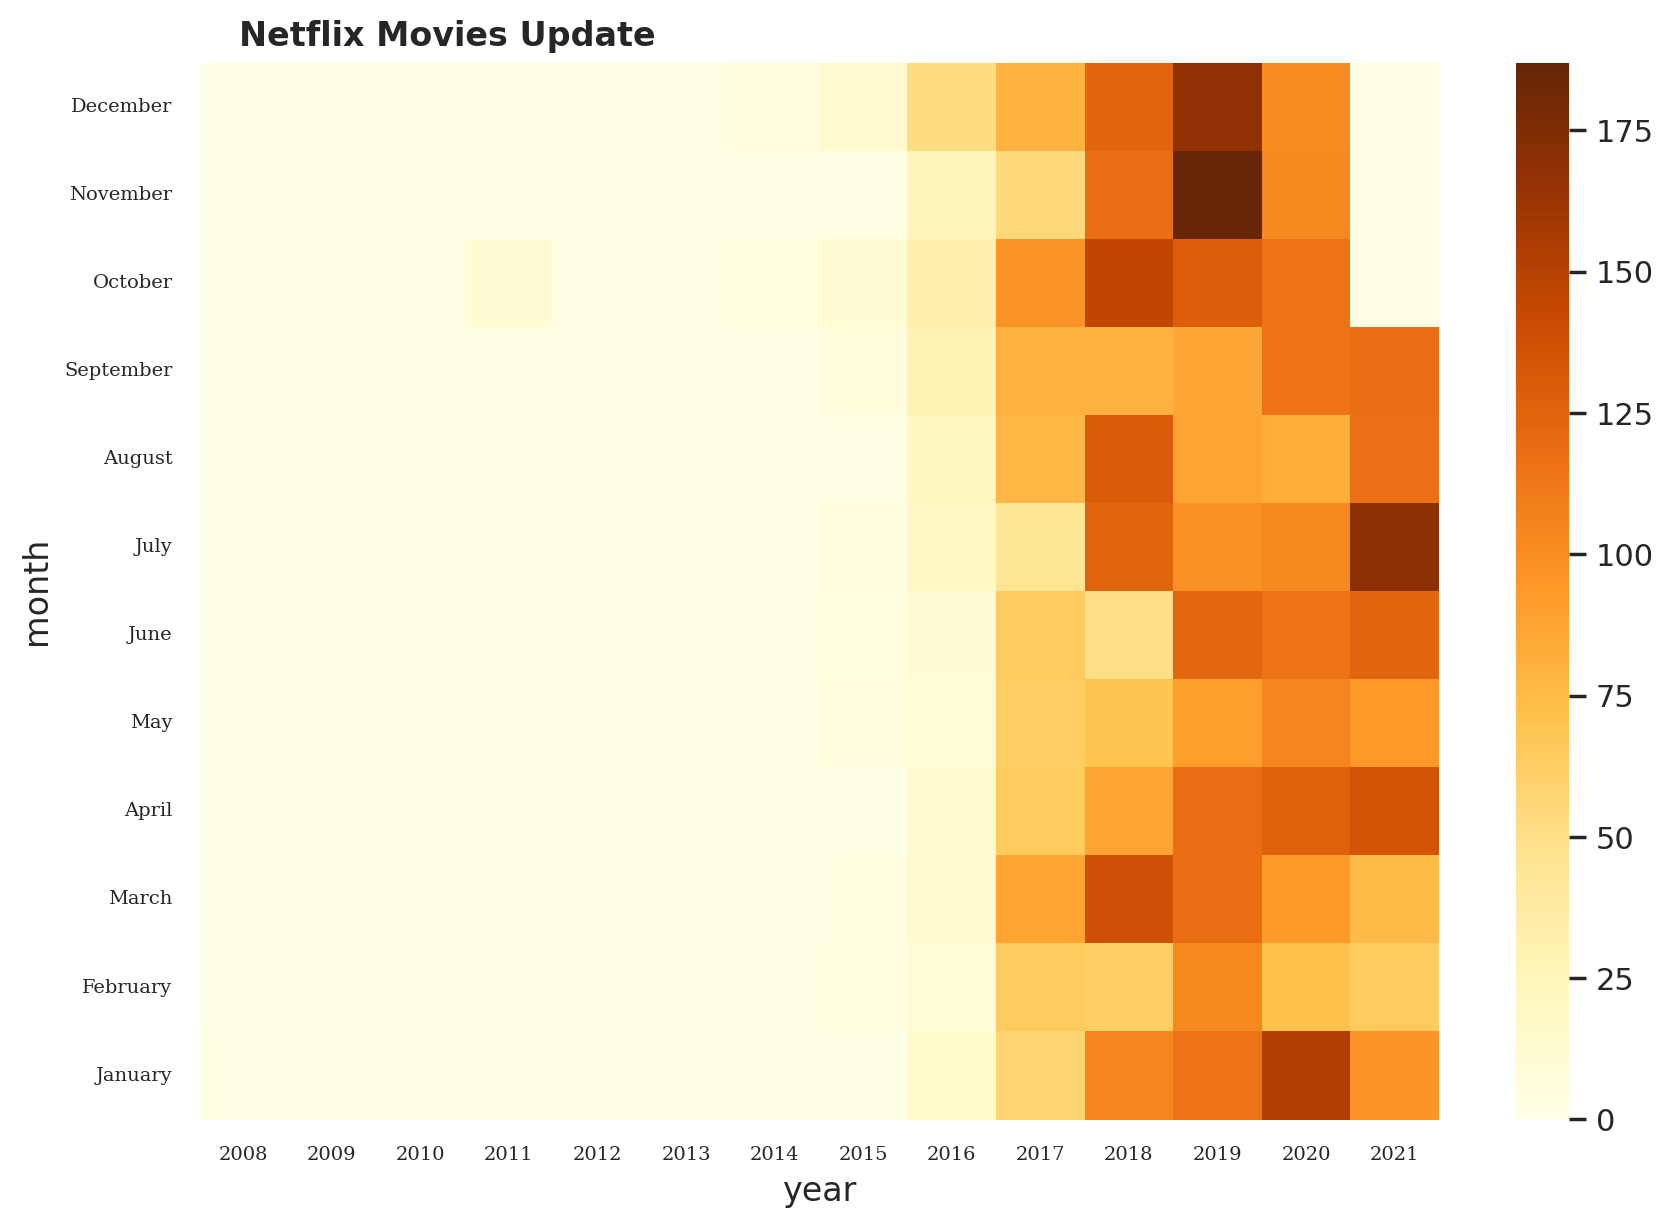

In [9]:
netflix_date = netflix_movies[['date_added']].dropna()
netflix_date['year'] = netflix_date['date_added'].apply(lambda x : x.split(', ')[-1])
netflix_date['month'] = netflix_date['date_added'].apply(lambda x : x.lstrip().split(' ')[0])

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'][::-1]
df = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

plt.figure(figsize=(10, 7), dpi=200)
sns.heatmap(df, cmap="YlOrBr")
plt.title('Netflix Movies Update', fontsize=12, fontfamily='calibri', fontweight='bold', position=(0.20, 1.0+0.02))
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=7, fontfamily='serif')
plt.show()

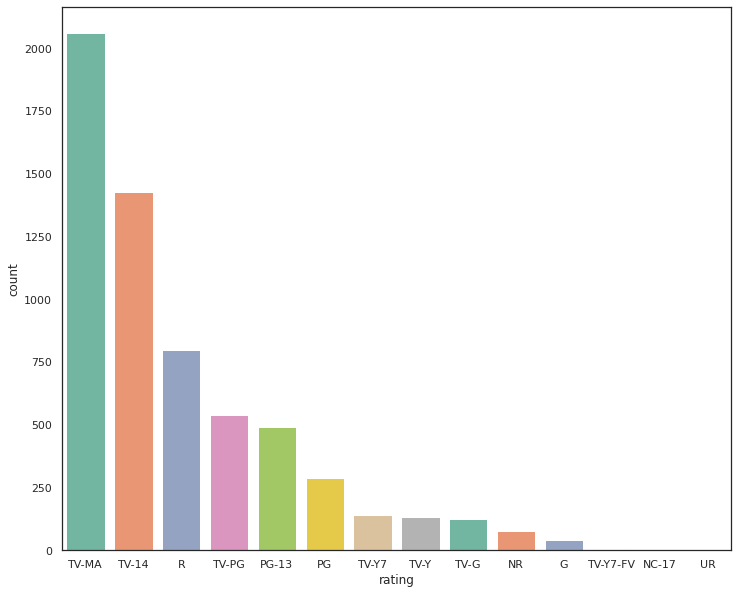

In [10]:
plt.figure(figsize=(12,10))
sns.set(style="white")
sns.countplot(x="rating", data=netflix_movies, palette="Set2", order=netflix_movies['rating'].value_counts().index[0:15])
plt.show()

# Year wise analysis

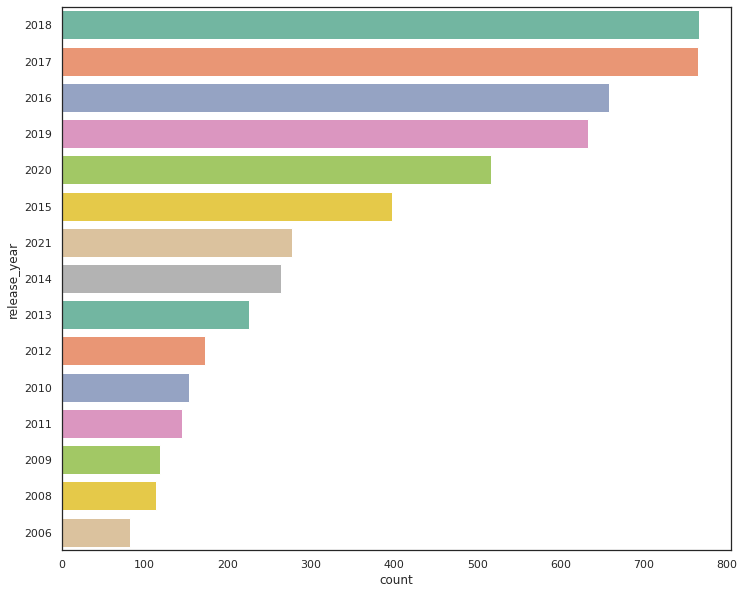

In [11]:
plt.figure(figsize=(12,10))
sns.set(style="white")
sns.countplot(y="release_year", data=netflix_movies, palette="Set2", order=netflix_movies['release_year'].value_counts().index[0:15])
plt.show()

In [12]:
countries={}
netflix_movies['country']=netflix_movies['country'].fillna('Unknown')
cou=list(netflix_movies['country'])
for i in cou:
    i=list(i.split(','))
    if len(i)==1:
        if i in list(countries.keys()):
            countries[i]+=1
        else:
            countries[i[0]]=1
    else:
        for j in i:
            if j in list(countries.keys()):
                countries[j]+=1
            else:
                countries[j]=1

In [13]:
countries_fin={}
for country,no in countries.items():
    country=country.replace(' ','')
    if country in list(countries_fin.keys()):
        countries_fin[country]+=no
    else:
        countries_fin[country]=no
countries_fin={k: v for k, v in sorted(countries_fin.items(), key=lambda item: item[1], reverse= True)}

# TOP 10 MOVIE CONTENT CREATING COUNTRIES

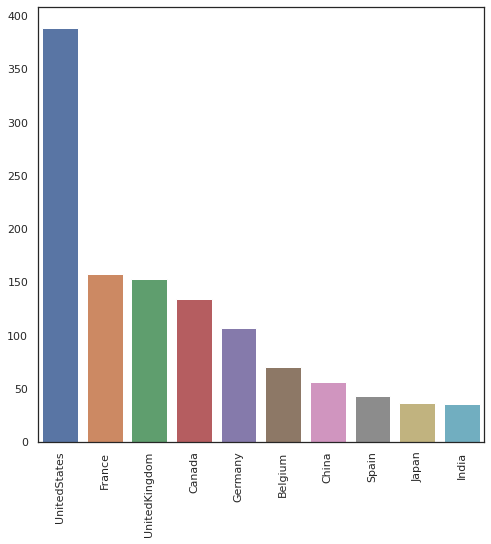

In [14]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x=list(countries_fin.keys())[0:10],y=list(countries_fin.values())[0:10])
ax.set_xticklabels(list(countries_fin.keys())[0:10],rotation = 90)
plt.show()

# Analysis of duration of movies

In [15]:
netflix_movies['duration']=netflix_movies['duration'].str.replace(' min','')
netflix_movies['duration']=netflix_movies['duration'].astype(str).astype(int)
netflix_movies['duration']

0        90
6        91
7       125
9       104
12      127
       ... 
8801     96
8802    158
8804     88
8805     88
8806    111
Name: duration, Length: 6128, dtype: int64

<AxesSubplot:xlabel='duration', ylabel='Density'>

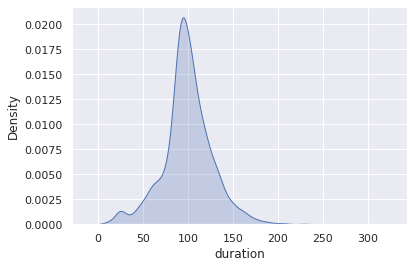

In [16]:
sns.set(style="darkgrid")
sns.kdeplot(data=netflix_movies['duration'], shade=True)

So, a good amount of movies on Netflix are among the duration of 75-120 mins. It is acceptable considering the fact that a fair amount of the audience cannot watch a 3 hour movie in one sitting.

In [17]:
from collections import Counter

genres=list(netflix_movies['listed_in'])
gen=[]

for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' ',""))
        
g=Counter(gen)

# Lollipop plot of Genres vs their count on Netflix

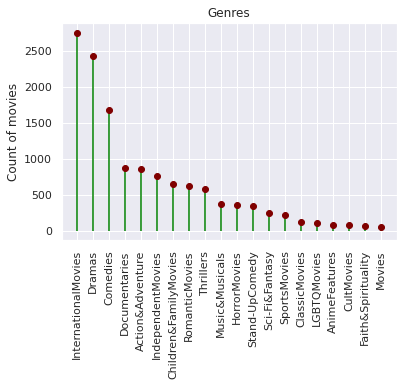

<Figure size 720x720 with 0 Axes>

In [18]:
g={k: v for k, v in sorted(g.items(), key=lambda item: item[1], reverse= True)}


fig, ax = plt.subplots()

fig = plt.figure(figsize = (10, 10))
x=list(g.keys())
y=list(g.values())
ax.vlines(x, ymin=0, ymax=y, color='green')
ax.plot(x,y, "o", color='maroon')
ax.set_xticklabels(x, rotation = 90)
ax.set_ylabel("Count of movies")
# set a title
ax.set_title("Genres");
plt.show()

Therefore, it is clear that international movies, dramas and comedies are the top three genres that have the highest amount of content on Netflix.

# Analysis of TV SERIES on Netflix

In [19]:
countries1={}
netflix_shows['country']=netflix_shows['country'].fillna('Unknown')
cou1=list(netflix_shows['country'])
for i in cou1:
    #print(i)
    i=list(i.split(','))
    if len(i)==1:
        if i in list(countries1.keys()):
            countries1[i]+=1
        else:
            countries1[i[0]]=1
    else:
        for j in i:
            if j in list(countries1.keys()):
                countries1[j]+=1
            else:
                countries1[j]=1

In [20]:
countries_fin1={}
for country,no in countries1.items():
    country=country.replace(' ','')
    if country in list(countries_fin1.keys()):
        countries_fin1[country]+=no
    else:
        countries_fin1[country]=no
        
countries_fin1={k: v for k, v in sorted(countries_fin1.items(), key=lambda item: item[1], reverse= True)}

# Most content creating countries

Text(0, 0.5, 'Arrival delay (in minutes)')

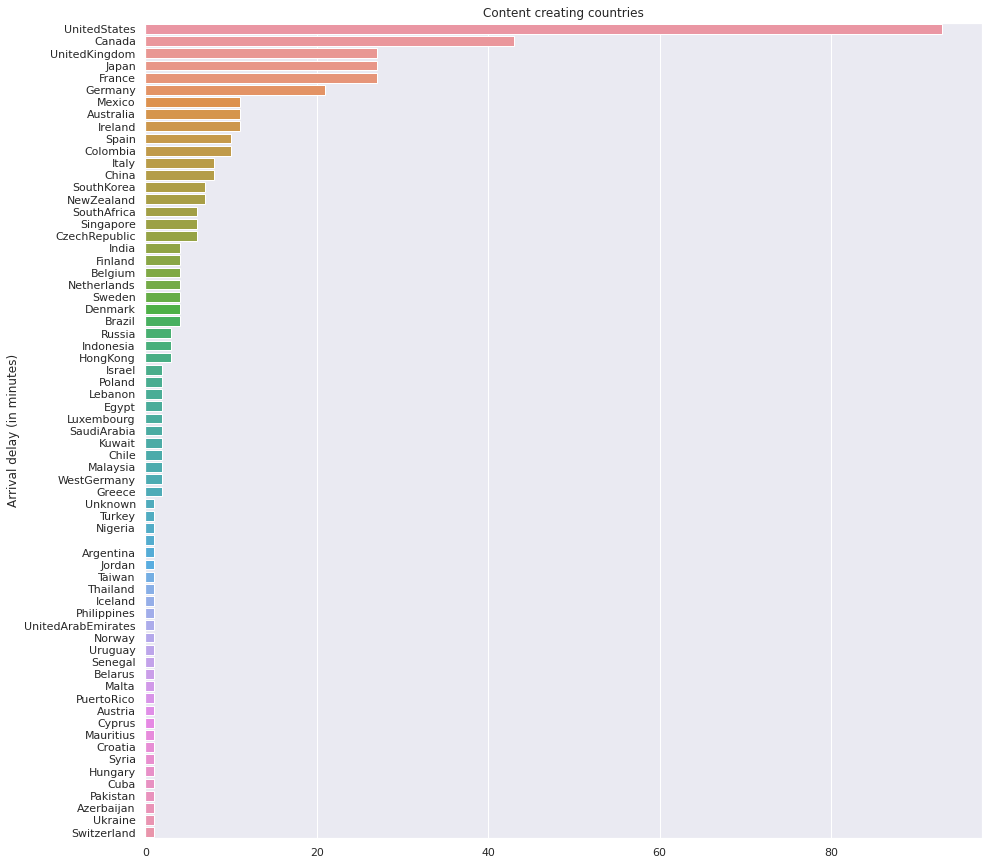

In [21]:
# Set the width and height of the figure
plt.figure(figsize=(15,15))

# Add title
plt.title("Content creating countries")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(y=list(countries_fin1.keys()), x=list(countries_fin1.values()))

# Add label for vertical axis
plt.ylabel("Arrival delay (in minutes)")

Naturally, United States has the most content that is created on netflix in the tv series category.

In [22]:
features=['title','duration']
durations= netflix_shows[features]

durations['no_of_seasons']=durations['duration'].str.replace(' Season','')
durations['no_of_seasons']=durations['no_of_seasons'].str.replace('s','')
durations['no_of_seasons']=durations['no_of_seasons'].astype(str).astype(int)

# TV shows with largest number of seasons

In [23]:
t=['title','no_of_seasons']
top=durations[t]

top=top.sort_values(by='no_of_seasons', ascending=False)

<AxesSubplot:xlabel='title'>

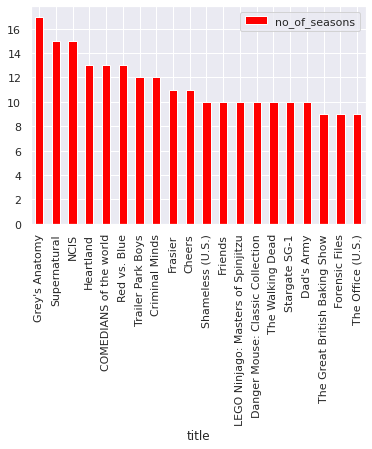

In [24]:
top20=top[0:20]
top20.plot(kind='bar',x='title',y='no_of_seasons', color='red')

# Recommendation System (Content Based)

The TF-IDF(Term Frequency-Inverse Document Frequency (TF-IDF) ) score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
netflix_overall['description'] = netflix_overall['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(netflix_overall['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(8804, 18894)

In [27]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [28]:
indices = pd.Series(netflix_overall.index, index=netflix_overall['title']).drop_duplicates()

In [29]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return netflix_overall['title'].iloc[movie_indices]

In [30]:
get_recommendations('Peaky Blinders')

7683                    Our Godfather
2646                   My Stupid Boss
3133                              Don
8293                         The Fear
7140    Jonathan Strange & Mr Norrell
7785                Power Rangers Zeo
8467                       The Prison
8539                       The Tudors
1510                    The Con Is On
8391     The Legend of Michael Mishra
Name: title, dtype: object

In [31]:
get_recommendations('Mortel')

256                       Nneka The Pretty Serpent
3674                  PILI Fantasy: War of Dragons
800                                Mosquita y Mari
4511         Edgar Rice Burroughs' Tarzan and Jane
6749                             Figures of Speech
7535    My Entire High School Sinking Into the Sea
6760                                     FirstBorn
4918                                 Psychokinesis
5481                                     Chamatkar
2190                          The Umbrella Academy
Name: title, dtype: object

It is seen that the model performs well, but is not very accurate.Therefore, more metrics are added to the model to improve performance.

# Content based filtering on multiple metrics

#### Content based filtering on the following factors:
<ul>
    <li>Title</li>
<li>Cast</li>
<li>Director</li>
<li>Listed in</li>
<li>Plot</li>
</ul>

Filling null values with empty string.

In [32]:
filledna=netflix_overall.fillna('')
filledna.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


Cleaning the data - making all the words lower case

In [33]:
def clean_data(x):
        return str.lower(x.replace(" ", ""))

Identifying features on which the model is to be filtered.

In [34]:
features=['title','director','cast','listed_in','description']
filledna=filledna[features]

In [35]:
for feature in features:
    filledna[feature] = filledna[feature].apply(clean_data)
    
filledna.head(2)

,title,director,cast,listed_in,description
0,dickjohnsonisdead,kirstenjohnson,,documentaries,"asherfathernearstheendofhislife,filmmakerkirst..."
1,blood&water,,"amaqamata,khosingema,gailmabalane,thabangmolab...","internationaltvshows,tvdramas,tvmysteries","aftercrossingpathsataparty,acapetownteensetsou..."


Creating a "soup" or a "bag of words" for all rows.

In [36]:
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

In [37]:
filledna['soup'] = filledna.apply(create_soup, axis=1)

From here on, the code is basically similar to the upper model except the fact that count vectorizer is used instead of tfidf.

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(filledna['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [39]:
filledna=filledna.reset_index()
indices = pd.Series(filledna.index, index=filledna['title'])

In [40]:
def get_recommendations_new(title, cosine_sim=cosine_sim):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return netflix_overall['title'].iloc[movie_indices]

In [41]:
get_recommendations_new('PK', cosine_sim2)

1114                           3 Idiots
8391       The Legend of Michael Mishra
4790                  Anthony Kaun Hai?
6907                             Haapus
1022                   Taare Zameen Par
4507                              Sanju
2720                            Dostana
4427                    Chance Pe Dance
6439                    Chal Dhar Pakad
195     EMI: Liya Hai To Chukana Padega
Name: title, dtype: object

In [42]:
get_recommendations_new('Peaky Blinders', cosine_sim2)

3034                    Giri / Haji
5032    The Frankenstein Chronicles
8431          The Murder Detectives
4951                         Loaded
4809                  Kiss Me First
6922                   Happy Valley
2184                       Get Even
519                   I AM A KILLER
3789                 Killer Ratings
4476          Terrorism Close Calls
Name: title, dtype: object

In [43]:
get_recommendations_new('Kota Factory', cosine_sim2)

2982                                        Find Yourself
1038                                       Dancing Angels
7438                     Melodies of Life - Born This Way
3293                                        Little Things
6508    Club Friday To Be Continued - My Beautiful Tomboy
7872                                           Rishta.com
3463                                      College Romance
4171                                    The Perfect Match
4487                                 Accidentally in Love
5703                                          Refresh Man
Name: title, dtype: object

# Recommendation System (Simple, Content Based, Collaborative Filtering, and Hybrid Recommender) on Movies Dataset

In [77]:
md = pd. read_csv('data/the-movies-dataset/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [78]:
# Convert genres dictionary into list
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [79]:
# Make new year column from released_date column.
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

## Content Based Recommender

The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 15 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.

To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as **Content Based Filtering.**

I will build two Content Based Recommenders based on:
* Movie Overviews and Taglines
* Movie Cast, Crew, Keywords and Genre

In [80]:
links_small = pd.read_csv('data/the-movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [81]:
md = md.drop([19730, 29503, 35587])

In [82]:
md['id'] = md['id'].astype('int')

In [83]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

In [86]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [87]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [88]:
tfidf_matrix.shape

(9099, 268124)

#### Cosine Similarity

I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [89]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [90]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [91]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [92]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [93]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

### Metadata Based Recommender

To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [94]:
credits = pd.read_csv('data/the-movies-dataset/credits.csv')
keywords = pd.read_csv('data/the-movies-dataset/keywords.csv')

In [95]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [96]:
md.shape

(45463, 25)

In [97]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [98]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

In [99]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [100]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [101]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [102]:
smd['director'] = smd['crew'].apply(get_director)

In [103]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [104]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [105]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [108]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [109]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [110]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [113]:
s = s[s > 1]

In [115]:
stemmer = SnowballStemmer('english')

In [116]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [117]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [118]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [119]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [120]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [121]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [122]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

In [123]:
get_recommendations('Mean Girls').head(10)

3319               Head Over Heels
1329              The House of Yes
6277              Just Like Heaven
7332    Ghosts of Girlfriends Past
7905         Mr. Popper's Penguins
4763                 Freaky Friday
6959     The Spiderwick Chronicles
8883                      The DUFF
6698         It's a Boy Girl Thing
7377       I Love You, Beth Cooper
Name: title, dtype: object

## Simple Recommender

The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user. 

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre. 

I use the TMDB Ratings to come up with our **Top Movies Chart.** I will use IMDB's *weighted rating* formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

The next step is to determine an appropriate value for *m*, the minimum votes required to be listed in the chart. We will use **95th percentile** as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

I will build our overall Top 250 Chart and will define a function to build charts for a particular genre. Let's begin!

In [60]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [61]:
m = vote_counts.quantile(0.95)
m

434.0

In [62]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

Therefore, to qualify to be considered for the chart, a movie has to have at least **434 votes** on TMDB. We also see that the average rating for a movie on TMDB is **5.244** on a scale of 10. **2274** Movies qualify to be on our chart.

In [63]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [64]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [65]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

### Top Movies

In [66]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


We see that three Christopher Nolan Films, **Inception**, **The Dark Knight** and **Interstellar** occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors. 

Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the **85th** percentile instead of 95. 

In [70]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [72]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

### Top Romance Movies

In [73]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


#### Popularity and Ratings

In [124]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [125]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
7583,Kick-Ass,4747,7,2010,6.852979
8682,The Equalizer,2997,7,2014,6.777990
1134,Batman Returns,1706,6,1992,5.846862
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943


## Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are *close* to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.
</br>
Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.
</br>
Therefore, in this section, we will use a technique called **Collaborative Filtering** to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.
</br>
I will not be implementing Collaborative Filtering from scratch. Instead, I will use the **Surprise** library that used extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [126]:
reader = Reader()
ratings = pd.read_csv("data/the-movies-dataset/ratings_small.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [127]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [128]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9040  0.8975  0.8972  0.8960  0.8936  0.8977  0.0035  
MAE (testset)     0.6983  0.6883  0.6912  0.6916  0.6884  0.6916  0.0036  
Fit time          4.82    12.11   12.26   4.91    4.77    7.78    3.60    
Test time         0.34    0.23    0.18    0.13    0.14    0.20    0.07    


{'test_rmse': array([0.9040384 , 0.89749951, 0.89723129, 0.89597201, 0.89360927]),
 'test_mae': array([0.69833856, 0.68828728, 0.6911688 , 0.69161742, 0.68844687]),
 'fit_time': (4.824689865112305,
  12.112006902694702,
  12.264684200286865,
  4.910082817077637,
  4.770086050033569),
 'test_time': (0.3364603519439697,
  0.2275373935699463,
  0.1772141456604004,
  0.1340479850769043,
  0.13834810256958008)}

We get a mean **Root Mean Sqaure Error** of 0.8977 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [129]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [130]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [131]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.7482671912576415, details={'was_impossible': False})

## Hybrid Recommender

In this section, I will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* **Input:** User ID and the Title of a Movie
* **Output:** Similar movies sorted on the basis of expected ratings by that particular user.

In [133]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [134]:
id_map = pd.read_csv('data/the-movies-dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [135]:
indices_map = id_map.set_index('id')

In [136]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [137]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
1011,The Terminator,4208.0,7.4,1984,218,3.091320
974,Aliens,3282.0,7.7,1986,679,3.024440
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,2.929330
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.918732
922,The Abyss,822.0,7.1,1989,2756,2.901471
1241,The Fifth Element,3962.0,7.3,1997,18,2.885511
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.823782
8231,Side by Side,111.0,7.1,2012,110354,2.798137
5310,Frank Herbert's Dune,114.0,6.7,2000,876,2.781802
4404,Treasure Planet,980.0,7.2,2002,9016,2.748476


In [138]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
1241,The Fifth Element,3962.0,7.3,1997,18,3.814308
974,Aliens,3282.0,7.7,1986,679,3.709248
1011,The Terminator,4208.0,7.4,1984,218,3.366978
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.301419
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.202703
2132,Superman II,642.0,6.5,1980,8536,3.093134
4347,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,3.053407
6084,Beastmaster 2: Through the Portal of Time,17.0,4.6,1991,27549,3.048182
8724,Jupiter Ascending,2816.0,5.2,2015,76757,3.046418
5310,Frank Herbert's Dune,114.0,6.7,2000,876,3.038722


## Conclusion

In this notebook, I have built 4 different recommendation engines based on different ideas and algorithms. They are as follows:

1. **Simple Recommender:** This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.
2. **Content Based Recommender:** We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.
3. **Collaborative Filtering:** We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.
4. **Hybrid Engine:** We brought together ideas from content and collaborative filterting to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.